In [1]:
%%time
import keras
keras.__version__

Using TensorFlow backend.


CPU times: user 548 ms, sys: 200 ms, total: 748 ms
Wall time: 573 ms


In [2]:
%%time
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  input_shape=(150,150, 3),
                  include_top=False)

CPU times: user 492 ms, sys: 48 ms, total: 540 ms
Wall time: 374 ms


In [3]:
%%time
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
%%time
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'digital_src_final/'

train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,88))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

    i = 0
    for inputs_batch, labels_batch in generator:
#         print(labels_batch)
#         print(inputs_batch)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 5280)
validation_features, validation_labels = extract_features(validation_dir,1760)
test_features, test_labels = extract_features(test_dir, 1760)

print(test_features.shape)
print(test_labels.shape)
print(test_features)

Found 5280 images belonging to 88 classes.
Found 1760 images belonging to 88 classes.
Found 1760 images belonging to 88 classes.
(1760, 4, 4, 512)
(1760, 88)
[[[[ 0.30536932  0.          0.         ...,  0.          0.01846081  0.        ]
   [ 0.08656953  0.          0.         ...,  0.          0.          0.        ]
   [ 0.13860333  0.          0.         ...,  0.          0.21558952  0.        ]
   [ 0.88561279  0.          0.         ...,  0.          0.4857797   0.        ]]

  [[ 0.44444883  0.          0.         ...,  0.          0.          0.        ]
   [ 0.          0.          0.         ...,  0.          0.          0.        ]
   [ 0.          0.          0.         ...,  0.60690182  0.20380619  0.        ]
   [ 0.99272394  0.          0.         ...,  0.03250607  0.          0.        ]]

  [[ 0.04284829  0.          0.         ...,  0.          0.          0.        ]
   [ 0.          0.          0.         ...,  0.          0.          0.        ]
   [ 0.          0

In [5]:
%%time
print(test_labels[0:20])
from keras.utils import to_categorical
test_labels = to_categorical(test_labels, 88)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 10.3 ms


In [6]:
print(test_labels.shape)

(1760, 88, 88)


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [7]:
train_features = np.reshape(train_features ,(5280,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1760, 4 * 4 * 512))
test_features = np.reshape(test_features, (1760, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [9]:
%%time
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(88, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 5280 samples, validate on 1760 samples
Epoch 1/50
5280/5280 [==============================] - 9s 2ms/step - loss: 4.4807 - acc: 0.0322 - val_loss: 4.2337 - val_acc: 0.1006
Epoch 2/50
5280/5280 [==============================] - 9s 2ms/step - loss: 4.1640 - acc: 0.0854 - val_loss: 3.9985 - val_acc: 0.2233
Epoch 3/50
5280/5280 [==============================] - 10s 2ms/step - loss: 3.9498 - acc: 0.1347 - val_loss: 3.7745 - val_acc: 0.3000
Epoch 4/50
5280/5280 [==============================] - 11s 2ms/step - loss: 3.7509 - acc: 0.1763 - val_loss: 3.5558 - val_acc: 0.3972
Epoch 5/50
5280/5280 [==============================] - 10s 2ms/step - loss: 3.5468 - acc: 0.2331 - val_loss: 3.3449 - val_acc: 0.5000
Epoch 6/50
5280/5280 [==============================] - 10s 2ms/step - loss: 3.3713 - acc: 0.2729 - val_loss: 3.1461 - val_acc: 0.5631
Epoch 7/50
5280/5280 [==============================] - 10s 2ms/step - loss: 3.1754 - acc: 0.3180 - val_loss: 2.9356 - val_acc: 0.6227
Epoch 8/5

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('digital.h5')

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(88, activation='softmax'))

This is what our model looks like now:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 88)                22616     
Total params: 16,834,712
Trainable params: 16,834,712
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [13]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

('This is the number of trainable weights before freezing the conv base:', 30)


In [14]:
conv_base.trainable = False

In [15]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

('This is the number of trainable weights after freezing the conv base:', 4)


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [16]:
%%time
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=0,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=0,
      horizontal_flip=False,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

#history = model.fit_generator(
      #train_generator,
      #steps_per_epoch=100,
      #epochs=30,
      #validation_data=validation_generator,
      #validation_steps=50,
      #verbose=2)

Found 5280 images belonging to 88 classes.
Found 1760 images belonging to 88 classes.
CPU times: user 296 ms, sys: 144 ms, total: 440 ms
Wall time: 355 ms


In [17]:
model.save('digital_01.h5')

Let's plot our results again:

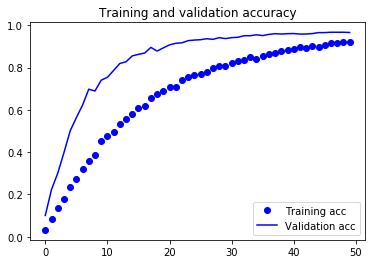

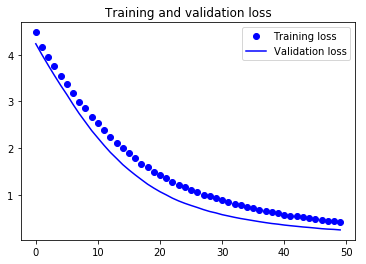

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [22]:
%%time
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=10, # 100
      epochs=10, # 100
      validation_data=validation_generator,
      validation_steps=15 ) # 50

Epoch 1/10
10/10 [==============================] - 181s 18s/step - loss: 2.3964 - acc: 0.5900 - val_loss: 2.1233 - val_acc: 0.6867
Epoch 2/10
10/10 [==============================] - 183s 18s/step - loss: 2.0320 - acc: 0.7150 - val_loss: 2.0134 - val_acc: 0.6800
Epoch 3/10
10/10 [==============================] - 185s 18s/step - loss: 1.8595 - acc: 0.7350 - val_loss: 1.9440 - val_acc: 0.6567
Epoch 4/10
10/10 [==============================] - 182s 18s/step - loss: 1.9186 - acc: 0.6700 - val_loss: 1.8447 - val_acc: 0.6867
Epoch 5/10
10/10 [==============================] - 192s 19s/step - loss: 1.7686 - acc: 0.7350 - val_loss: 1.7670 - val_acc: 0.7000
Epoch 6/10
10/10 [==============================] - 185s 18s/step - loss: 1.6295 - acc: 0.7500 - val_loss: 1.6646 - val_acc: 0.7567
Epoch 7/10
10/10 [==============================] - 191s 19s/step - loss: 1.6235 - acc: 0.7700 - val_loss: 1.5645 - val_acc: 0.7600
Epoch 8/10
10/10 [==============================] - 193s 19s/step - loss: 1.

In [23]:
model.save('digital_02.h5')

Let's plot our results using the same plotting code as before:

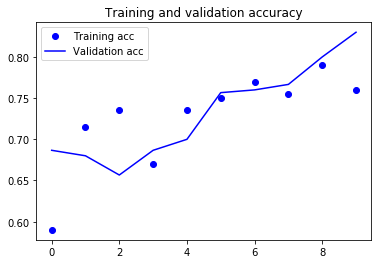

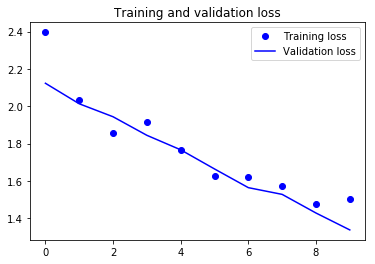

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

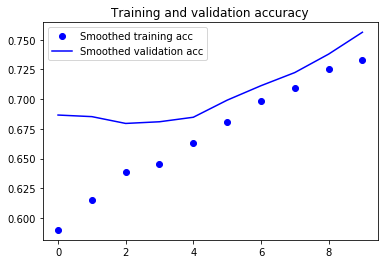

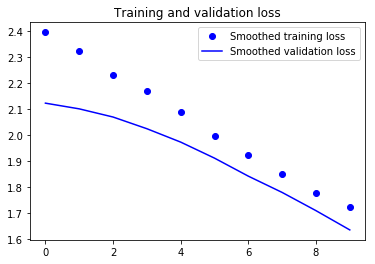

In [26]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [27]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50) # use steps = 50
print('test acc:', test_acc)

Found 1760 images belonging to 88 classes.
('test acc:', 0.82499999999999996)
CPU times: user 19min 39s, sys: 23.9 s, total: 20min 3s
Wall time: 5min 57s



Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.